In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
%matplotlib

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    funcdir    = op.join(wd, 'analysis', 'tools')
    sys.path.insert(0, funcdir)
os.chdir(wd)
sys.path.insert(0, eyefuncdir)
import eyefuncs as eyes
from funcs import clusterperm_test

eyedir = op.join(wd, 'data', 'eyes')
bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26])
nsubs = subs.size

#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy')), 2)
eyetimes   = np.round(np.load(op.join(wd, 'data', 'glms', 'glm3', 'eyetracker_times.npy')), 2)
regnames   = np.load(op.join(wd, 'data', 'glms', 'glm3', 'regressor_names.npy'))

nparams = regnames.size
#ppts x tuning curve timepoints x regressors x
b = np.zeros(shape = [nsubs, modeltimes.size, nparams, eyetimes.size]) * np.nan
t = np.zeros(shape = [nsubs, modeltimes.size, nparams, eyetimes.size]) * np.nan

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
use_b = True
if use_b:
    paramind = 0
    addtext = 'modelAmplitudeBeta'
elif not use_b:
    paramind = 1
    addtext = 'modelAmplitudeTvalue'
fittype = 'opt'
if fittype == 'opt':
    fittext = 'b1optfit'
elif fittype == 'glm':
    fittext = 'b1glmfit'
b = np.zeros(shape = [nsubs, regnames.size, modeltimes.size, eyetimes.size]) * np.nan
t = np.zeros_like(b) * np.nan
subcount = -1
for sub in subs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'glm3', f'wmc_s{sub:02d}_glm3_betas_{fittext}_{addtext}.npy')) #has shape: tuning curve time x regressors x eyetracker time
    it = np.load(op.join(wd, 'data', 'glms', 'glm3', f'wmc_s{sub:02d}_glm3_tvalues_{fittext}_{addtext}.npy'))
    b[subcount] = ib.copy()
    t[subcount] = it.copy()
bm = np.nanmean(b, axis=0) #average across participants
tm = np.nanmean(t, axis=0)

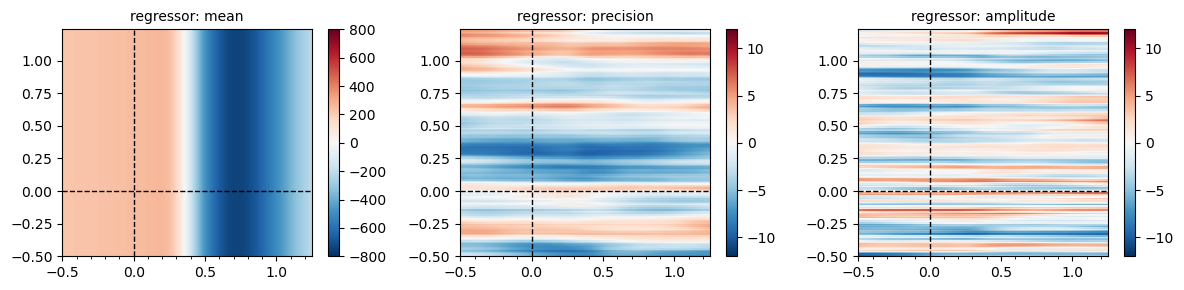

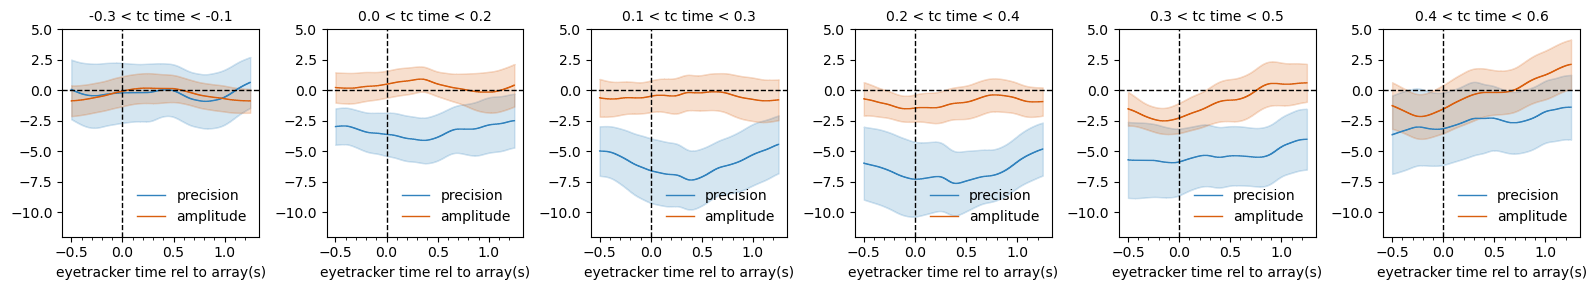

In [3]:
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -800, 800
    else:
        vmin, vmax = -12, 12
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(bm[iparam].squeeze(), aspect= 'auto', interpolation='none', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eyetimes.min(), eyetimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = b[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eyetimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eyetimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)
    ax.set_ylim([-12, 5])
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.set_xlabel('eyetracker time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'lower right', frameon=False)
fig.tight_layout()

stat_fun(H1): min=-2.209488008677452 max=1.3332584246552792
Running initial clustering …
Found 5 clusters


C:\Users\sammirc\anaconda3\envs\mne\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 65534/65534 [00:04<00:00, 14032.35it/s]


cluster p-values for precision regressor: [0.14683757 0.41011673 0.35844968 0.28822766 0.48694591]
stat_fun(H1): min=-3.6458385925078343 max=2.6381135691676927
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 24466.18it/s]

cluster p-values for amplitude regressor: [0.04556344 0.71433585 0.44179446]
stat_fun(H1): min=-2.28958748086042 max=1.5103073907910232


Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 27532.23it/s]

cluster p-values for precision regressor: [0.12112612 0.34572366 0.34799725 0.09057755]
stat_fun(H1): min=-3.906131507875514 max=2.575970080374124
Running initial clustering …
Found 3 clusters



100%|██████████| Permuting : 65534/65534 [00:02<00:00, 23529.83it/s]


cluster p-values for amplitude regressor: [0.03448539 0.65755703 0.46163119]
stat_fun(H1): min=-2.2827657838616333 max=1.4492156881403564
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 27012.28it/s]

cluster p-values for precision regressor: [0.12043946 0.40257877 0.35191882 0.11276417]
stat_fun(H1): min=-3.858013143274331 max=2.636211886162054
Running initial clustering …
Found 3 clusters



100%|██████████| Permuting : 65534/65534 [00:02<00:00, 24264.98it/s]


cluster p-values for amplitude regressor: [0.03512627 0.66591897 0.45040055]


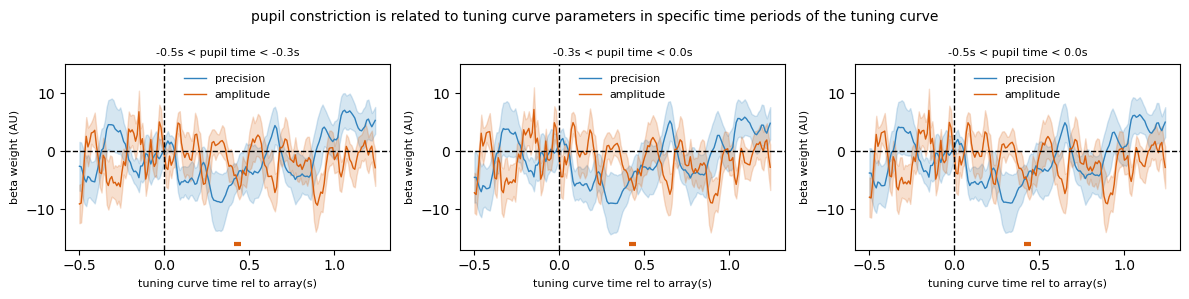

In [4]:
#params for cluster forming
alpha = 0.05
df = nsubs
t_thresh = sp.stats.t.ppf(1-alpha, df = df)
tmin, tmax = 0, 0.75 #time-window for cluster permutation testing


mstarts = [-0.5, -0.3, -0.5]
mends   = [-0.3,  0.0, 0.0]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
labs = ['precision', 'amplitude']
fig = plt.figure(figsize = [nplots*4, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eyetimes >= istart, eyetimes <= iend)
    idat = b[:,:,:,tinds].mean(-1)
    # idat = sp.ndimage.gaussian_filter1d(idat, sigma = 2)
    for ireg in range(2):
        # plotd = b[:,:,:,tinds].mean(-1)
        plotd = idat[:,ireg+1] #take just the relevant parameter
        plotm = plotd.mean(axis=0) #average across participants
        plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
    
        ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm, plotsem),
                        np.subtract(plotm, plotsem),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < pupil time < {iend}s', fontsize = 8)
    ax.set_ylim([-17, 15])
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)

    #run cluster permutation stats
    for reg in ['precision', 'amplitude']:
        if reg == 'precision':
            icol = '#3182bd'
            ih = -15
        elif reg == 'amplitude':
            icol = '#d95f0e'
            ih = -16
        tv, clu, clupv, _ = clusterperm_test(data = idat,
                                        labels = regnames, of_interest = reg, times = modeltimes,
                                        tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = 'all', #run all possible permutations (exact permutation test)
                                        threshold = -t_thresh, tail = -1, #one-tailed
                                        n_jobs=4)
        clu = [x[0] for x in clu]
        print(f'cluster p-values for {reg} regressor: {clupv}')
        times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
        nclus = len(clu)
        for icluster in range(nclus):
            mask = clu[icluster]
            if clupv[icluster] <= alpha:
                itmin = times_twin[mask[0]]
                itmax = times_twin[mask[-1]]
                ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)
        
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.suptitle('pupil constriction is related to tuning curve parameters in specific time periods of the tuning curve', fontsize = 10)
fig.tight_layout()

<font color='blue'>

same but with t-values from each participant instead of beta values

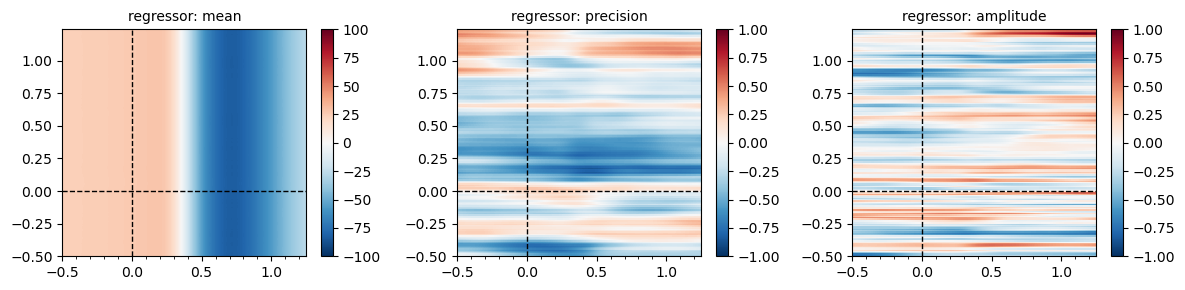

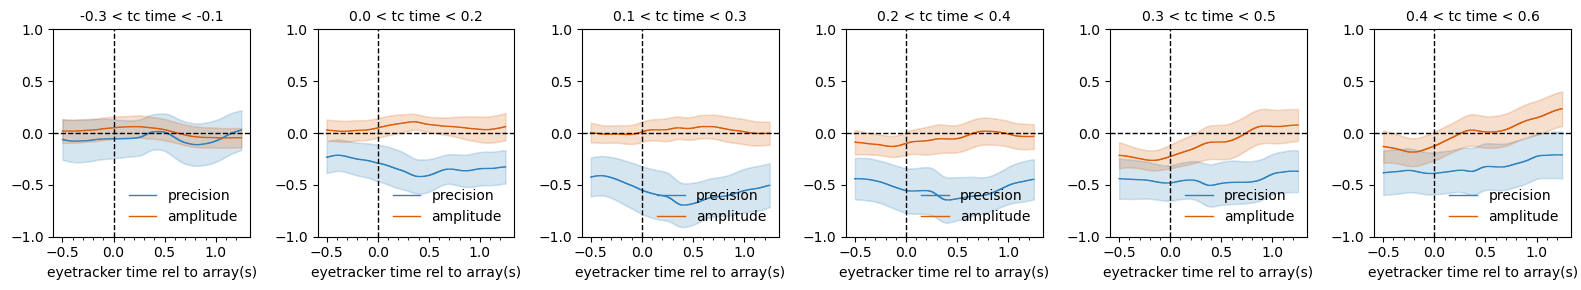

In [5]:
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -100, 100
    else:
        vmin, vmax = -1, 1
    ax = fig.add_subplot(1, 3, iparam+1)
    plot = ax.imshow(tm[iparam].squeeze(), aspect= 'auto', interpolation='none', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eyetimes.min(), eyetimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = t[:, :, tinds].mean(axis=2) #average across the timewindow
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(2):
        ax.plot(eyetimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eyetimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < tc time < {iend}', fontsize = 10)
    ax.set_ylim([-1, 1])
    ax.set_xticks(np.arange(-0.5, 1.25, 0.1), minor=True)
    ax.set_xlabel('eyetracker time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'lower right', frameon=False)
fig.tight_layout()

stat_fun(H1): min=-2.167865048951182 max=1.7914961091125712
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 26976.57it/s]

cluster p-values for precision regressor: [0.45160601 0.4774548  0.04592966]
stat_fun(H1): min=-2.9148082489805947 max=2.4168564612106676
Running initial clustering …
Found 4 clusters



100%|██████████| Permuting : 65534/65534 [00:02<00:00, 23766.15it/s]


cluster p-values for amplitude regressor: [0.87719539 0.06425574 0.65831998 0.10847639]
stat_fun(H1): min=-2.4677892138283277 max=1.3612117617916815
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 24994.61it/s]


cluster p-values for precision regressor: [0.43131151 0.4184329  0.56571298 0.03735409]
stat_fun(H1): min=-3.326497837277836 max=2.402989967983981
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 23322.91it/s]


cluster p-values for amplitude regressor: [0.04368658 0.72439155 0.88201724 0.09561303]
stat_fun(H1): min=-2.3473293168018303 max=1.5151009339722454
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 26815.48it/s]


cluster p-values for precision regressor: [0.43698787 0.42095064 0.0393225 ]
stat_fun(H1): min=-3.2115710517868563 max=2.444113170510451
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 25481.72it/s]


cluster p-values for amplitude regressor: [0.04812696 0.70138094 0.09803922]


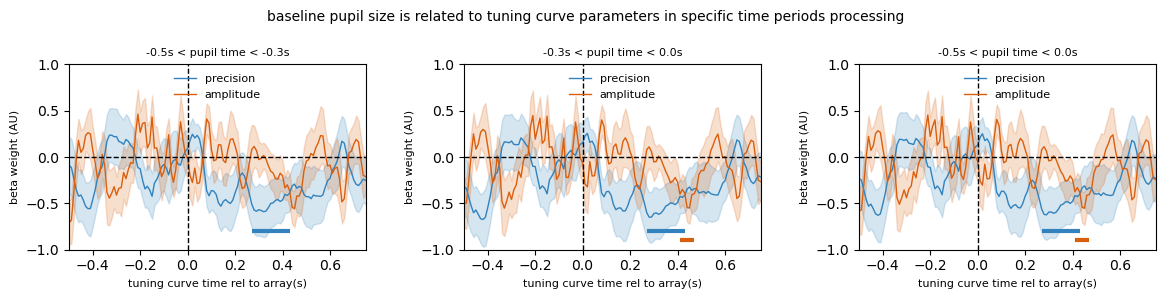

In [6]:
#params for cluster forming
alpha = 0.05
df = nsubs
t_thresh = sp.stats.t.ppf(1-alpha, df = df)
tmin, tmax = 0, 1 #time-window for cluster permutation testing


mstarts = [-0.5, -0.3, -0.5]
mends   = [-0.3,  0.0, 0.0]
nplots = len(mstarts)
cols = ['#3182bd', '#d95f0e']
labs = ['precision', 'amplitude']
fig = plt.figure(figsize = [nplots*4, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    ax = fig.add_subplot(1, nplots, iplot+1)
    # print(iplot, istart, iend)
    tinds = np.logical_and(eyetimes >= istart, eyetimes <= iend)
    idat = t[:,:,:,tinds].mean(-1)
    # idat = sp.ndimage.gaussian_filter1d(idat, sigma = 2)
    for ireg in range(2):
        plotd = idat[:,ireg+1] #take just the relevant parameter
        plotm = plotd.mean(axis=0) #average across participants
        plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')
    
        ax.plot(modeltimes, plotm, label = labs[ireg], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm, plotsem),
                        np.subtract(plotm, plotsem),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart}s < pupil time < {iend}s', fontsize = 8)
    ax.set_ylim([-1, 1])
    ax.set_xlabel('tuning curve time rel to array(s)', fontsize = 8)
    ax.set_ylabel('beta weight (AU)', fontsize = 8)

    #run cluster permutation stats
    for reg in ['precision', 'amplitude']:
        if reg == 'precision':
            icol = '#3182bd'
            ih = -0.8
        elif reg == 'amplitude':
            icol = '#d95f0e'
            ih = -0.9
        tv, clu, clupv, _ = clusterperm_test(data = idat,
                                        labels = regnames, of_interest = reg, times = modeltimes,
                                        tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = 'all', #run all possible permutations (exact permutation test)
                                        threshold = -t_thresh, tail = -1, #one-tailed
                                        n_jobs=4)
        clu = [x[0] for x in clu]
        print(f'cluster p-values for {reg} regressor: {clupv}')
        times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
        nclus = len(clu)
        for icluster in range(nclus):
            mask = clu[icluster]
            if clupv[icluster] <= alpha:
                itmin = times_twin[mask[0]]
                itmax = times_twin[mask[-1]]
                ax.hlines(y = ih, xmin = itmin, xmax = itmax, lw = 3, color = icol, alpha = 1)
    ax.set_xlim([-0.5, 0.75])
    ax.legend(loc = 'upper center', frameon=False, fontsize=8)
fig.suptitle('baseline pupil size is related to tuning curve parameters in specific time periods processing', fontsize = 10)
fig.tight_layout()